# Desafio 2 - NLP

- Crear sus propios vectores con Gensim basado en lo visto en clase con otro dataset.
- Probar términos de interés y explicar similitudes en el espacio de embeddings.
- Intentar plantear y probar tests de analogías. 
- Graficar los embeddings resultantes.
- Sacar conclusiones.

## Imports

In [240]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing
from gensim.models import Word2Vec
import os
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from nltk.corpus import stopwords
import nltk
from gensim.models.callbacks import CallbackAny2Vec
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.decomposition import IncrementalPCA    
from sklearn.manifold import TSNE                   
import numpy as np
import plotly.graph_objects as go
import plotly.express as px                   

## Funciones generales

In [20]:
# Durante el entrenamiento gensim por defecto no informa el "loss" en cada época
# Sobrecargamos el callback para poder tener esta información
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

In [199]:
def reduce_dimensions(model, num_dimensions = 2 ):
     
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)  

    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    return vectors, labels

In [124]:
def max_words (model, vecs, labels, highlight_words, MAX_WORDS, topn=10):
    all_words = list(labels)
    selected_words = set(highlight_words)

    for word in highlight_words:
        if word in model.wv:
            try:
                similar = model.wv.most_similar(word, topn=topn)
                selected_words.update([w for w, _ in similar])
            except KeyError:
                pass  # por si alguna palabra no está en vocabulario

    for word in all_words:
        if len(selected_words) >= MAX_WORDS:
            break
        if word not in selected_words:
            selected_words.add(word)

    selected_words = list(selected_words)
    indices = [all_words.index(w) for w in selected_words if w in all_words]
    filtered_vecs = vecs[indices]
    filtered_labels = [all_words[i] for i in indices]
    return filtered_vecs, filtered_labels

In [ ]:
def plot_embeddings(model, vecs, labels, MAX_WORDS=200, highlight_words=None):
    assert vecs.shape[0] == len(labels), "Vecs y labels deben tener la misma longitud"
    vecs, labels = max_words(model, vecs, labels, highlight_words, MAX_WORDS)
    # Colores: rojo si está en highlight, azul si no
    highlight_words = set(highlight_words) if highlight_words else set()
    colors = ['red' if word in highlight_words else 'blue' for word in labels]

    if vecs.shape[1] == 2:
        fig = px.scatter(
            x=vecs[:, 0],
            y=vecs[:, 1],
            text=labels,
            color=colors,
            labels={"color": "Tipo de palabra"}
        )
    elif vecs.shape[1] == 3:
        fig = px.scatter_3d(
            x=vecs[:, 0],
            y=vecs[:, 1],
            z=vecs[:, 2],
            text=labels,
            color=colors,
            labels={"color": "Tipo de palabra"}
        )
        fig.update_traces(marker_size = 2)
    else:
        raise ValueError("Los vectores deben ser de dimensión 2 o 3")

    fig.update_traces(textposition='top center')
    fig.show()

In [ ]:
def embeddings_matrix_distance(model, words, extra_vector=None, extra_label="nuevo"):
    emb = np.array([model.wv.get_vector(word) for word in words])
    if extra_vector is not None:
        emb = np.vstack([emb, extra_vector])
        words = words + [extra_label]
    dist = cosine_similarity(emb, emb)
    plot_matrix_distance(words, dist)


def plot_matrix_distance(words, dist):
    fig = plt.figure(figsize=(16,9))
    ax = fig.add_subplot()
    sns.heatmap(dist, xticklabels=words, yticklabels=words, 
                annot=True, fmt=".2f", cmap="YlGnBu", ax=ax, mask=np.triu(dist))
    plt.show()

## Preprocesamiento

In [6]:
os.listdir("corpus")

['Indiana_Jones_And_The_Last_Crusade.txt',
 'Indiana_Jones_And_The_Temple_Of_Doom.txt',
 'Raiders_Of_The_Lost_Ark.txt']

In [39]:
df1 = pd.read_csv('corpus/Indiana_Jones_And_The_Last_Crusade.txt', sep='/n', header=None, engine='python')
df2 = pd.read_csv('corpus/Raiders_Of_The_Lost_Ark.txt', sep='/n', header=None, engine='python')
df3 = pd.read_csv('corpus/Indiana_Jones_And_The_Temple_Of_Doom.txt', sep='/n', header=None, engine='python')
df = pd.concat([df1, df2, df3], ignore_index=True)
display(df.head())
display("Cantidad de documentos:", df.shape[0])

,0
0,"""INDIANA JONES AND THE LAST CRUSADE"""
1,Screenplay by
2,Jeffrey Boam
3,FADE IN:
4,EXT. DESERT OF THE AMERICAN SOUTHWEST - DAY


'Cantidad de documentos:'

13504

In [205]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) 

sentence_tokens = []
for _, row in df[:None].iterrows():
    tokens = text_to_word_sequence(row[0])  # Tokenizar con Keras
    filtered_tokens = [word for word in tokens if word not in stop_words]
    sentence_tokens.append(filtered_tokens)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pablo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Crear los vectores (word2vec)

In [410]:
w2v_model = Word2Vec(min_count=4,    # frecuencia mínima de palabra para incluirla en el vocabulario
                     window=10,       # cant de palabras antes y desp de la predicha
                     vector_size=384,       # dimensionalidad de los vectores 
                     negative=25,    # cantidad de negative samples... 0 es no se usa
                     workers=4,      # si tienen más cores pueden cambiar este valor
                     sg=1)           # modelo 0:CBOW  1:skipgram

In [411]:
w2v_model.build_vocab(sentence_tokens)
display("Cantidad de docs en el corpus:", w2v_model.corpus_count)
display("Cantidad de words distintas en el corpus:", len(w2v_model.wv.index_to_key))

'Cantidad de docs en el corpus:'

13504

'Cantidad de words distintas en el corpus:'

2214

In [412]:
w2v_model.train(sentence_tokens,
                 total_examples=w2v_model.corpus_count,
                 epochs=80,
                 compute_loss = True,
                 callbacks=[callback()]
                 )

Loss after epoch 0: 240826.15625
Loss after epoch 1: 150839.3125
Loss after epoch 2: 149583.28125
Loss after epoch 3: 146860.375
Loss after epoch 4: 145704.75
Loss after epoch 5: 143735.375
Loss after epoch 6: 135027.5
Loss after epoch 7: 122613.625
Loss after epoch 8: 120529.0
Loss after epoch 9: 118266.625
Loss after epoch 10: 117367.375
Loss after epoch 11: 114075.125
Loss after epoch 12: 111275.125
Loss after epoch 13: 109326.875
Loss after epoch 14: 107419.125
Loss after epoch 15: 101973.625
Loss after epoch 16: 94862.25
Loss after epoch 17: 92919.5
Loss after epoch 18: 90917.0
Loss after epoch 19: 88870.5
Loss after epoch 20: 88629.25
Loss after epoch 21: 85988.75
Loss after epoch 22: 84712.0
Loss after epoch 23: 82321.0
Loss after epoch 24: 81923.5
Loss after epoch 25: 79936.0
Loss after epoch 26: 78837.25
Loss after epoch 27: 78721.25
Loss after epoch 28: 76581.5
Loss after epoch 29: 75329.25
Loss after epoch 30: 74879.5
Loss after epoch 31: 73935.75
Loss after epoch 32: 75145.

(2879376, 3869760)

## Pruebas

In [413]:
w2v_model.wv.most_similar(positive=["grail"], topn=10)

[('diary', 0.5147437453269958),
 ('pages', 0.47497767210006714),
 ('knight', 0.47345587611198425),
 ('sinister', 0.468417227268219),
 ('page', 0.46794793009757996),
 ('forget', 0.46477797627449036),
 ('attempt', 0.4613129794597626),
 ('complete', 0.44744569063186646),
 ('america', 0.44711625576019287),
 ('seal', 0.43660858273506165)]

En este caso podemos ver como la palabra que mas correlación tiene con Grial es Diario, en la pelicula "Indiana Jones y la última cruzada", se menciona varias veces al diario del grial donde estaba la información de como encontrarlo. 

In [414]:
w2v_model.wv.most_similar(positive=["ark"], topn=10)

[('covenant', 0.5530259013175964),
 ('crated', 0.5009047389030457),
 ('poles', 0.48809751868247986),
 ('lid', 0.44593220949172974),
 ('rod', 0.4147621691226959),
 ('shut', 0.3858519196510315),
 ('tightly', 0.3854084610939026),
 ('arrives', 0.3763621747493744),
 ('press', 0.36941632628440857),
 ('bouncing', 0.3688600957393646)]

En "Indiana Jones y los cazadores del arca perdida" la famosa arca se llama "el arca de la alianza" por eso la mejor correlación es con esa palabra.

In [415]:
w2v_model.wv.most_similar(positive=["sankara"], topn=10)

[('stones', 0.7067492008209229),
 ('stolen', 0.6373118162155151),
 ('sacred', 0.6338757276535034),
 ('bag', 0.5764142274856567),
 ('jai', 0.5697948336601257),
 ('brothers', 0.5533120036125183),
 ('magical', 0.5509536862373352),
 ('goddess', 0.538970410823822),
 ('legend', 0.5352293848991394),
 ('gave', 0.5351132750511169)]

En "Indiana Jones y el templo de la pedición" el objeto que Indy debe rescatar era la Piedra de Sankara, que eran unas piedras sagradas.

In [419]:
w2v_model.wv.most_similar(negative=["soldiers"], topn=10)

[('overlapping', 0.03946489468216896),
 ('interrupting', 0.017486264929175377),
 ('slightly', 0.010745308361947536),
 ('antidote', -0.00045634430716745555),
 ('subtitled', -0.0036324181128293276),
 ('vial', -0.00890352763235569),
 ('around', -0.010200455784797668),
 ('crawls', -0.012410992756485939),
 ('poison', -0.018366843461990356),
 ('smiling', -0.02246083877980709)]

Para la relación inversa no es que se detecten antonimos, sino palabras que no estan muy relacionadas en el espacio del embedding. No podemos sacar mucha conclusión del ejemplo.

## Visualizar agrupación de vectores

In [422]:
vecs, labels = reduce_dimensions(w2v_model)

MAX_WORDS=500
plot_embeddings(w2v_model, vecs, labels, MAX_WORDS, highlight_words=["grail","ark","sankara"])

In [421]:
vecs, labels = reduce_dimensions(w2v_model,3)

MAX_WORDS=200
plot_embeddings(w2v_model, vecs, labels, MAX_WORDS, highlight_words=["grail","ark","sankara"])

### Test de analogía

[('complete', 0.4235042929649353),
 ('christ', 0.4234042763710022),
 ('glory', 0.3971552550792694),
 ('somewhere', 0.3876826763153076),
 ('fortune', 0.3774627447128296),
 ('america', 0.3658566474914551),
 ('embrace', 0.3529066741466522),
 ('knee', 0.3415004312992096)]

0.4234044

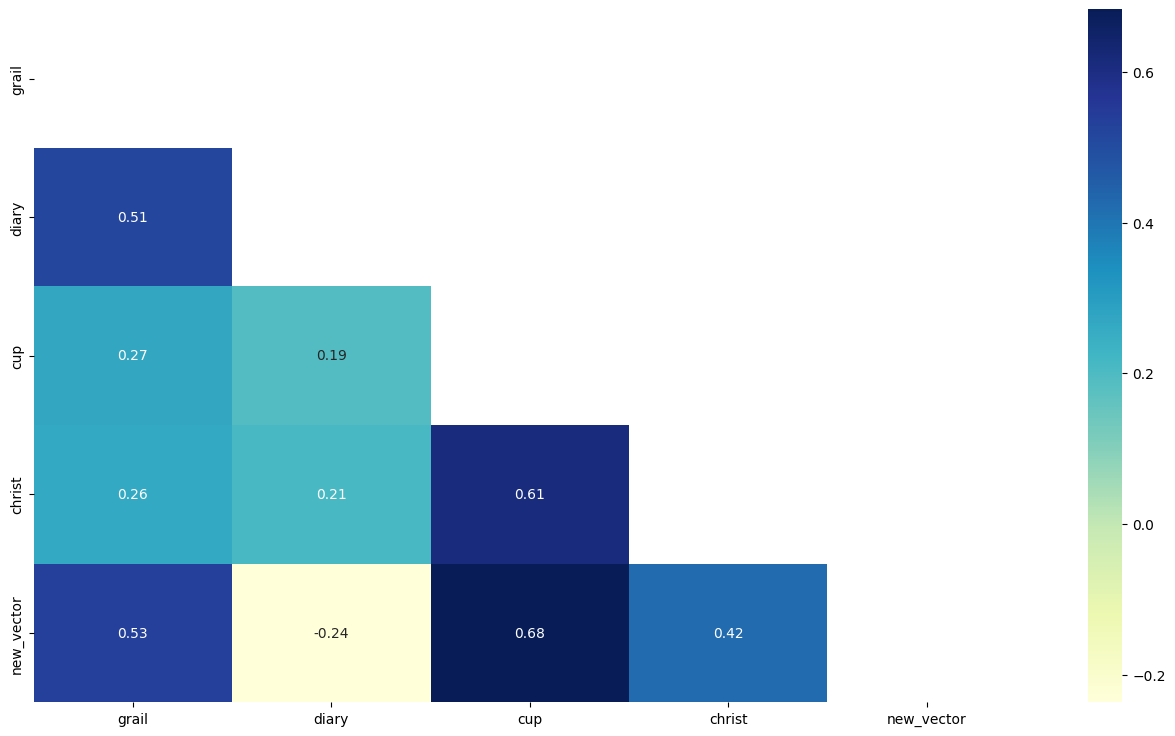

In [436]:
words = ["grail","diary","cup"]
vector1 = w2v_model.wv.get_vector(words[0])
vector2 = w2v_model.wv.get_vector(words[1])
vector3 = w2v_model.wv.get_vector(words[2])

new_vector = vector1 - vector2 + vector3

display(w2v_model.wv.most_similar(new_vector)[2:])
display(cosine_similarity([new_vector], [w2v_model.wv.get_vector("christ")])[0][0])
words.append("christ")
embeddings_matrix_distance(w2v_model, words, new_vector, "new_vector")

Se intentó hacer el test de analogía con referirise al Santo Grial como la copa y no como el diario, la correlación no es muy fuerte, pero dentro de lo mas próximo tenemos a Cristo.